### Customer Lifetime Value prediction

### Modelling the problem

###### For calculating the CLV of each customer for the next 6 months, we'll need to predict the expected number of transactions and the average profit per customer.
###### For these tasks, I will use two Probabilistic Methods:
###### - BG/NBD (Beta-Geometric/Negative Binomial Distribution) Model --- for the numbers of transactions
###### - Gamma-Gamma Model --- for the average profit per customer

### Importing the packages and preparing the data

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.cluster import KMeans

from sklearn.metrics import mean_squared_error

from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_period_transactions
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.datasets import load_cdnow_summary_data_with_monetary_value

import datetime as dt

### Loading the data and preprocessing

In [39]:
df = pd.read_csv(filepath_or_buffer="./data/customer_segmentation.csv", encoding="cp1252") # Specify the encoding!

## Verifying the existence of NaN values
df.isna().sum()

## Drop the NaN values
df.dropna(inplace=True)

df.info()



df = df.drop(columns=['StockCode', 'Description'])

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    406829 non-null  object 
 1   StockCode    406829 non-null  object 
 2   Description  406829 non-null  object 
 3   Quantity     406829 non-null  int64  
 4   InvoiceDate  406829 non-null  object 
 5   UnitPrice    406829 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      406829 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.9+ MB


### Setting data types

In [40]:
df['InvoiceNo'] = df['InvoiceNo'].astype('str')
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['CustomerID'] = df['CustomerID'].astype('str')
df['Country'] = df['Country'].astype('str')
df['UnitPrice'] = df['UnitPrice'].apply(float)

#### Create a new field / feature from existing ones

In [41]:
df['InvoiceYearMonth'] = df['InvoiceDate'].map(lambda date: 100*date.year + date.month).apply(float)
df['Revenue'] = df['UnitPrice'] * df['Quantity'] # This should be predicted!
df['Revenue'] = df['Revenue'].apply(float)

In [42]:
df.describe()

#  std -- standard deviation --  a measure of how the dispersed the data is in relation to the mean

,Quantity,InvoiceDate,UnitPrice,InvoiceYearMonth,Revenue
count,406829.000000,406829,406829.000000,406829.000000,406829.000000
mean,12.061303,2011-07-10 16:30:57.879207424,3.460471,201101.006123,20.401854
min,-80995.000000,2010-12-01 08:26:00,0.000000,201012.000000,-168469.600000
25%,2.000000,2011-04-06 15:02:00,1.250000,201104.000000,4.200000
50%,5.000000,2011-07-31 11:48:00,1.950000,201107.000000,11.100000
75%,12.000000,2011-10-20 13:06:00,3.750000,201110.000000,19.500000
max,80995.000000,2011-12-09 12:50:00,38970.000000,201112.000000,168469.600000
std,248.693370,NaN,69.315162,23.877089,427.591718


### Create the summary data

In [43]:
df_rfmt = summary_data_from_transaction_data(transactions=df, customer_id_col='CustomerID', datetime_col='InvoiceDate', monetary_value_col='Revenue')

print(df_rfmt.head())

# frequency = the count of days the customer had a purchase on
# recency = the duration between a customer's first purchase and the end of the period
# T = the duration between a customer's first and latest purchase
# monetary_value = the sum of all a customer's purchases devided by the total number of purchases 

            frequency  recency      T  monetary_value
CustomerID                                           
12346.0           0.0      0.0  325.0        0.000000
12347.0           6.0    365.0  367.0      599.701667
12348.0           3.0    283.0  358.0      301.480000
12349.0           0.0      0.0   18.0        0.000000
12350.0           0.0      0.0  310.0        0.000000


### Calculating the time frame of our data set

In [44]:
time_frame = df['InvoiceDate'].max() - df['InvoiceDate'].min()
print(time_frame)

373 days 04:24:00


### Splitting the data in training model and testing model

In [45]:
end_date_cal = df['InvoiceDate'].min() + dt.timedelta(days=193)
end_date_hold = end_date_cal + (time_frame - dt.timedelta(days=193))

# Similar with the method train_test_split
df_rfmt_cal = calibration_and_holdout_data(transactions=df, customer_id_col="CustomerID", datetime_col="InvoiceDate", calibration_period_end=end_date_cal, observation_period_end=end_date_hold)


In [46]:
df_rfmt_cal.info()
df_rfmt_cal.keys()

<class 'pandas.core.frame.DataFrame'>
Index: 2855 entries, 12346.0 to 18287.0
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   frequency_cal      2855 non-null   float64
 1   recency_cal        2855 non-null   float64
 2   T_cal              2855 non-null   float64
 3   frequency_holdout  2855 non-null   float64
 4   duration_holdout   2855 non-null   float64
dtypes: float64(5)
memory usage: 133.8+ KB


Index(['frequency_cal', 'recency_cal', 'T_cal', 'frequency_holdout',
       'duration_holdout'],
      dtype='object')

### Fitting the model BG/NBD to predict the number of transactions

####        Focusing on the transactions' occurences

The error is: 2.89722865183682


c:\Users\Maria Fugulin\.conda\envs\pytorch_env\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Maria Fugulin\.conda\envs\pytorch_env\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: title={'center': 'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

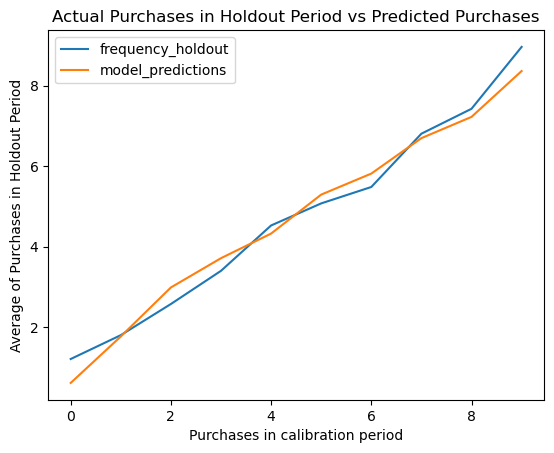

In [47]:
bg_model = BetaGeoFitter(penalizer_coef=0.1)
bg_model.fit(df_rfmt_cal['frequency_cal'], 
        df_rfmt_cal['recency_cal'], 
        df_rfmt_cal['T_cal'])

pred_freq = pd.DataFrame(bg_model.predict(df_rfmt_cal['duration_holdout'], 
                                       df_rfmt_cal['frequency_cal'], 
                                       df_rfmt_cal['recency_cal'], 
                                       df_rfmt_cal['T_cal']), 
                                       columns=['predicted_frequency']).reset_index()


aux_df = df_rfmt_cal.reset_index().merge(pred_freq, on='CustomerID').dropna() 

# Calculating the RMS error (how far predictions fall from measured true values using Euclidean distance.)
rms_error = np.sqrt(mean_squared_error(aux_df['frequency_holdout'], aux_df['predicted_frequency'])) 

print(f"The error is: {rms_error}")

plot_calibration_purchases_vs_holdout_purchases(bg_model, df_rfmt_cal, 
                                                kind='frequency_cal', 
                                                n = 10)


### Verifying the BG/NBD model

<Axes: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

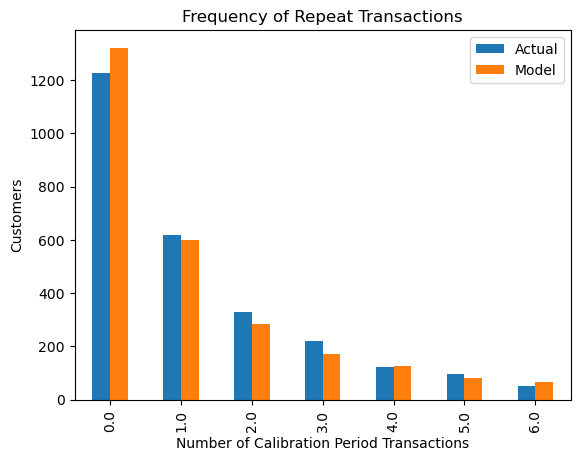

In [48]:
plot_period_transactions(bg_model)

### Frequency/Recency Matrix

<Axes: title={'center': 'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

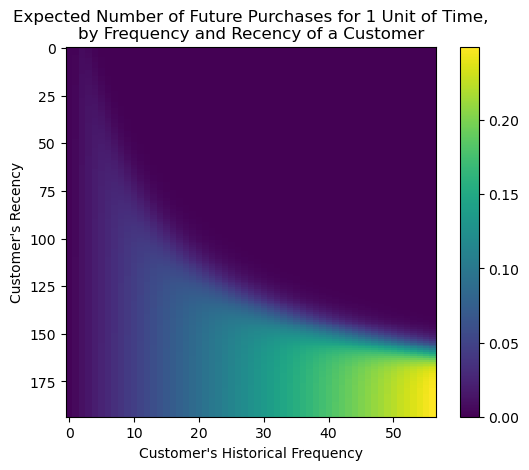

In [49]:
plot_frequency_recency_matrix(bg_model)

# The best customer is in the bottom-right corner
# The coldest customers are the ones who bought a lot quickly and they did'nt buy for weeks 

# The tail represents a customer that buys infrequently, but was seen recently, a possibility that the customer might buy again

### Probability of still being alive

<Axes: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

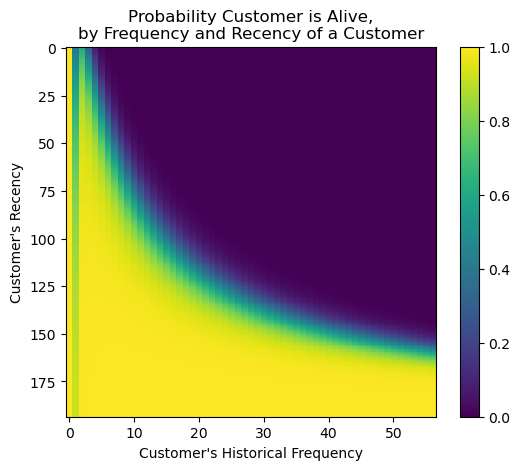

In [50]:
plot_probability_alive_matrix(bg_model)

### Predicting number of purchases for the next 6 months for each customer

In [52]:

df_rfmt['predicted_purchases'] = bg_model.conditional_expected_number_of_purchases_up_to_time(180, 
                                                                                      df_rfmt['frequency'], 
                                                                                      df_rfmt['recency'], 
                                                                                      df_rfmt['T'])



# Drop the NaN values
df_rfmt.dropna(inplace=True)

# Getting rid of negative values
df_rfmt = df_rfmt[df_rfmt['monetary_value']>0]

print("Expected conditional no. purchases: %s, Average no. purchases: %s" % (
    bg_model.conditional_expected_number_of_purchases_up_to_time(180, 
                                                                df_rfmt['frequency'], 
                                                                df_rfmt['recency'], 
                                                                df_rfmt['T']
                                                                ).mean(),
    df_rfmt[df_rfmt['monetary_value']>0]['frequency'].mean()
))


# Ranking customers from best to worst
df_rfmt.sort_values(by='predicted_purchases', ascending = False).head(10)



Expected conditional no. purchases: 3.4494739303418296, Average no. purchases: 5.256795422031473


,frequency,recency,T,monetary_value,predicted_purchases
CustomerID,,,,,
14911.0,145.0,372.0,373.0,910.463724,64.334211
12748.0,114.0,373.0,373.0,254.975000,50.631389
17841.0,112.0,372.0,373.0,355.421429,49.746484
15311.0,90.0,373.0,373.0,655.266778,40.021933
14606.0,88.0,372.0,373.0,130.858295,39.137211
13089.0,82.0,367.0,369.0,690.871707,36.846193
12971.0,71.0,369.0,372.0,153.311831,31.698900
16422.0,66.0,352.0,369.0,486.931667,29.662743
14527.0,63.0,371.0,373.0,122.839365,28.085374


### Estimating the economic value of a customer using the Gamma-Gamma model


##### Verifying if the Gamma-Gamma model independece assumption is true

In [54]:

summary_with_money_value = df_rfmt
summary_with_money_value.head()
returning_customers_summary = summary_with_money_value[summary_with_money_value['frequency']>0]

print(returning_customers_summary.head())
returning_customers_summary[['monetary_value', 'frequency']].corr()


## The correlation value is 0.1749 that it is close to 0, indicating that there is a weak relationship between them (there is no linear relationship between them)
## We can continue using the Gamma-Gamma model 

            frequency  recency      T  monetary_value  predicted_purchases
CustomerID                                                                
12347.0           6.0    365.0  367.0      599.701667             2.931254
12348.0           3.0    283.0  358.0      301.480000             1.615823
12352.0           6.0    260.0  296.0      208.151667             3.557333
12356.0           2.0    303.0  325.0      269.905000             1.265347
12358.0           1.0    149.0  150.0      683.200000             1.390891


,monetary_value,frequency
monetary_value,1.000000,0.174984
frequency,0.174984,1.000000


#### Calculating the economic value of each transaction

In [55]:
gamma_model = GammaGammaFitter(penalizer_coef=0.001)
gamma_model.fit(df_rfmt['frequency'], df_rfmt['monetary_value'])

<lifetimes.GammaGammaFitter: fitted with 2796 subjects, p: 10.68, q: 0.89, v: 10.82>

### Predicting the spending using the Gamma-Gamma model 

In [56]:
print("Expected conditional average profit: %s, Average profit: %s" % (
    gamma_model.conditional_expected_average_profit(
        df_rfmt['frequency'],
        df_rfmt['monetary_value']
    ).mean(),
    df_rfmt[df_rfmt['frequency']>0]['monetary_value'].mean()
))

Expected conditional average profit: 345.5356410337239, Average profit: 339.2490770584033


### Predicting the CLV for the next 6 months for each customer

In [57]:
df_rfmt['CLV'] = gamma_model.customer_lifetime_value(
    bg_model,
    df_rfmt['frequency'],
    df_rfmt['recency'],
    df_rfmt['T'],
    df_rfmt['monetary_value'],
    time = 6,
    )

df_rfmt 


,frequency,recency,T,monetary_value,predicted_purchases,CLV
CustomerID,,,,,,
12347.0,6.0,365.0,367.0,599.701667,2.931254,1705.967656
12348.0,3.0,283.0,358.0,301.480000,1.615823,477.785820
12352.0,6.0,260.0,296.0,208.151667,3.557333,722.654573
12356.0,2.0,303.0,325.0,269.905000,1.265347,338.217056
12358.0,1.0,149.0,150.0,683.200000,1.390891,941.989611
...,...,...,...,...,...,...
18273.0,2.0,255.0,257.0,76.500000,1.561977,124.216044
18277.0,1.0,260.0,318.0,110.380000,0.711230,84.120703
18282.0,2.0,119.0,126.0,38.195000,2.837658,120.137270


### Finding the optimal number of clusters using the Elbow Method

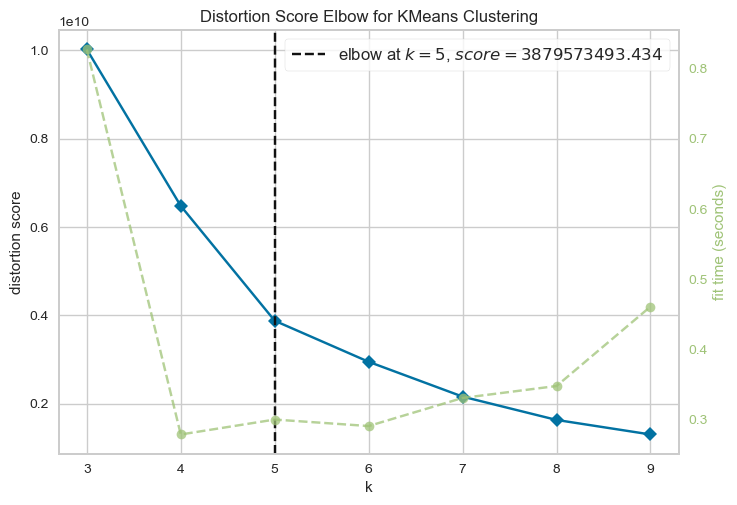

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [58]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

from yellowbrick.cluster import KElbowVisualizer


km_model = KMeans()
visualizer = KElbowVisualizer(km_model, k=(3, 10))

visualizer.fit(df_rfmt)
visualizer.show()

### Customers classification using the KMeans algorithm

In [59]:
km_model = KMeans(n_clusters=5)
km_model.fit(df_rfmt)



df_rfmt['cluster'] = km_model.labels_


# Grouping by clusters

df_clusters = df_rfmt.groupby(['cluster'])['CLV'].aggregate(['mean', 'count']).reset_index()
df_clusters.columns = ["cluster", "Average CLV", "Number of customers"]


df_clusters['percentage'] = (df_clusters["Number of customers"]/df_clusters["Number of customers"].sum())*100
df_clusters.sort_values(by='Average CLV', ascending = False) 





,cluster,Average CLV,Number of customers,percentage
4,4,114319.428946,2,0.071531
1,1,63947.646960,5,0.178827
2,2,19657.610193,22,0.786838
3,3,4105.633993,262,9.370529
0,0,701.855559,2505,89.592275


In [62]:
# Rename the clusters

df_rfmt['category'] = df_rfmt['cluster'].replace({4: "Platinum", 1: "Gold", 2: "Silver", 3: "Bronze", 0: "Iron"})

### Calculating the cluster that impacts the most the Total CLV for the next 6 months

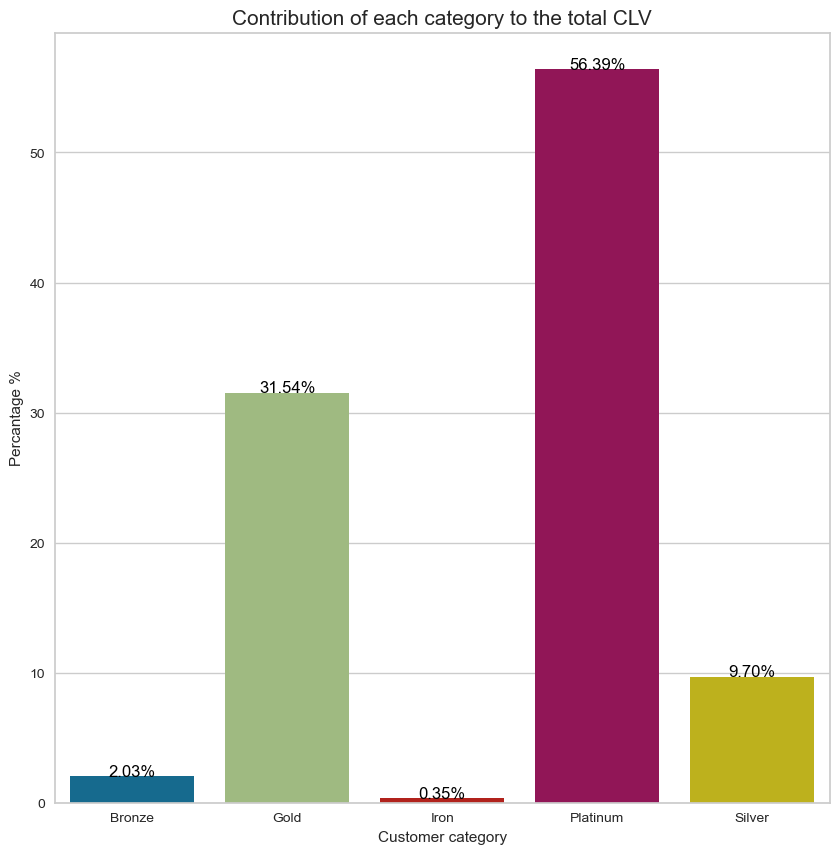

In [63]:
df_category = pd.DataFrame(df_rfmt.groupby(['category'])['CLV'].aggregate('mean')).reset_index()

df_category['Contribution'] = df_category['CLV']/df_category['CLV'].sum() * 100


plt.figure(figsize=(10,10))

plot = sns.barplot(x = "category", y = "Contribution", data = df_category)


plt.xlabel("Customer category")

plt.ylabel("Percantage %")

plt.title("Contribution of each category to the total CLV", size=15)

for index, row in df_category.iterrows():
    plt.text(index, row['Contribution'], f"{row['Contribution']:.2f}%", color='black', ha="center")

## Conclusions

#### We can observe that the Platinum and Gold categories contribute to almost 88% to the total CLV, even though they represent merely 0.19% from the total percentage of customers. 